## Checking the feasibility of the payload

The idea here is to get a sense of what kind of events would be possible to detect by our accelerometer. This model will be a 2D model of 1km x 1km, with the parameters defined as follows.

Velocity of p-wave=3km

Velocity of s_wave=1.5km

Density of the medium(assumed uniform)=2 g/cc

The boundary conditions are as follows:

The top surface has free boundary surface.

The other three surfaces have absorbing boundary conditions(ideally completely).

The impact of the micrometeoroid will be modelled by ricker source(though actually a delta function) which is tuned for the maximum intensity at the frequency of our accelerometer detection.The acceleration is capable of sampling rate from  19.5Hz to 952Hz, but we'll take the middle of capacity which is approximately 500Hz and the more standard 50 HZ also. Also the intensity of the source will be based on the expected force generated by the impact of largest micrometeoroid which we want to analyse.From the payload analysis doc, we have:

time for collision= 1ms

Mass considered=15 micrograms

Velocity=13300km/s

So the average force during the time of impact amounts to approximately 0.2N.

#### NOTE: This notebook largely borrows the boundary conditions as in devito/examples/userapi/boundary_conditions.


In [ ]:
#importing files required for processing
import numpy  as np
import matplotlib.pyplot as plt
%matplotlib inline
#for devito we'll import the required functions when the need arises.
from devito import Grid,TimeFunction, VectorTimeFunction, TensorTimeFunction,div, grad, curl, diag,SubDomain
from examples.seismic import ModelElastic, plot_velocity, TimeAxis, RickerSource, plot_image

In [2]:
# NOw defining the subdoamins and the boundary conditions that will be used using the subdomains
nbpml=10# number of absorbing boundary layers/perfectly matched layers

class MainDomain(SubDomain):  # Main section with no damping
    name = 'main'
    def __init__(self, PMLS):
        super().__init__()
        self.PMLS = PMLS
            

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', self.PMLS, self.PMLS), y: ('middle', 0, self.PMLS)}


class Left(SubDomain):  # Left PML region
    name = 'left'
    def __init__(self, PMLS):
        super().__init__()
        self.PMLS = PMLS

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('left', self.PMLS), y: y}


class Right(SubDomain):  # Right PML region
    name = 'right'
    def __init__(self, PMLS):
        super().__init__()
        self.PMLS = PMLS

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('right', self.PMLS), y: y}
    
    
class Base(SubDomain):  # Base PML region
    name = 'base'
    def __init__(self, PMLS):
        super().__init__()
        self.PMLS = PMLS

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', self.PMLS, self.PMLS), y: ('right', self.PMLS)}


main_domain = MainDomain(nbpml)
left = Left(nbpml)
right = Right(nbpml)
base = Base(nbpml)

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s


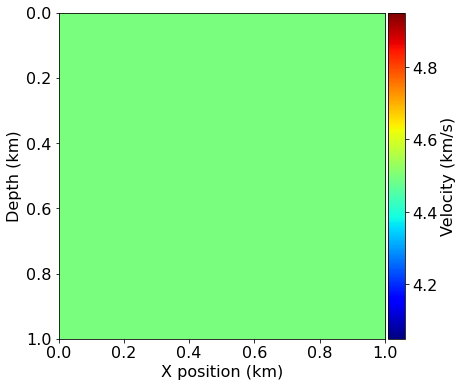

In [3]:

from examples.seismic import ModelElastic, plot_velocity

# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
# As the initial model is uniform taking
vp=3*np.ones(shape=shape)
vs=1.5*np.ones(shape=shape)# defining constant velocity at each point in domain
density=2
# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = ModelElastic(vp=vp,vs=vs,origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="mask",subdomains=(main_domain,left,right,base))
# bcs=mask, as we are implementing the damping condiitions using subdoamins
plot_velocity(model)

# note that here in the entire domain the sum of the p wave and s wave velocity sum is represented.

In [4]:
from devito import TimeFunction, VectorTimeFunction, NODE

p = TimeFunction(name='p', grid=model.grid, time_order=1,
                 space_order=2, staggered=NODE)
v = VectorTimeFunction(name='v', grid=model.grid, time_order=1,
                       space_order=2)

In [5]:
print(v[0].data)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [6]:
p_i = TimeFunction(name='p_i', grid=model.grid, time_order=1,
                   space_order=1, staggered=NODE)

x,y=model.grid.dimensions

In [7]:
# Damping parameterisation
d_l = (1-0.1*x)**2  # Left side
d_r = (1-0.1*(model.grid.shape[0]-1-x))**2  # Right side
d_b = (1-0.1*(model.grid.shape[1]-1-y))**2  # Base edge

In [8]:
import numpy as np
from examples.seismic import TimeAxis, RickerSource

t0 = 0.  # Simulation starts at t=0
tn = 1000.  # Simulation length in ms
dt = 0.02 # Time step

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.5# the source frequency
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range,a=0.2)

# Position source centrally in all dimensions
src.coordinates.data[0, :] = 500
src.coordinates.data[0, -1] = 0.

src_term = src.inject(field=p.forward, expr=src)



In [9]:
from devito import Eq, grad, div
vel=3# velocity of p wave
eq_v = Eq(v.forward, v - dt*grad(p)/density,
          subdomain=model.grid.subdomains['main'])

eq_p = Eq(p.forward, p - dt*vel**2*density*div(v.forward),
           subdomain=model.grid.subdomains['main'])

In [10]:
eq_p_i = Eq(p_i.forward, p_i + dt*(p.forward+p)/2)

In [11]:
gamma = 0.0002

# Left side

eq_v_damp_left = Eq(v.forward,
                    (1-d_l)*v - dt*grad(p)/density,
                    subdomain=model.grid.subdomains['left'])

eq_p_damp_left = Eq(p.forward,
                    (1-gamma*vel**2*dt-d_l*dt)*p
                    - d_l*gamma*vel**2*p_i
                    - dt*vel**2*density*div(v.forward),
                    subdomain=model.grid.subdomains['left'])

# Right side
eq_v_damp_right = Eq(v.forward,
                     (1-d_r)*v - dt*grad(p)/density,
                     subdomain=model.grid.subdomains['right'])

eq_p_damp_right = Eq(p.forward,
                     (1-gamma*vel**2*dt-d_r*dt)*p
                     - d_r*gamma*vel**2*p_i
                     - dt*vel**2*density*div(v.forward),
                     subdomain=model.grid.subdomains['right'])

# Base edge
eq_v_damp_base = Eq(v.forward,
                    (1-d_b)*v - dt*grad(p)/density,
                    subdomain=model.grid.subdomains['base'])

eq_p_damp_base = Eq(p.forward,
                    (1-gamma*vel**2*dt-d_b*dt)*p
                    - d_b*gamma*vel**2*p_i
                    - dt*vel**2*density*div(v.forward),
                    subdomain=model.grid.subdomains['base'])

In [12]:
def freesurface_top(p_func, v_func):
    time = p_func.grid.stepping_dim
    pos = int(max(p_func.space_order, v_func.space_order)/2)
    
    bc_p = [Eq(p[time+1, x, pos], 0.)]
    bc_v = [Eq(v[1][time+1, x, i], -v[1][time+1, x, 2*pos-i]) for i in range(pos)]
    
    return bc_p + bc_v

bc = freesurface_top(p, v)

In [13]:
from examples.seismic import Receiver

# Create symbol for 101 receivers
rec = Receiver(name='rec', grid=model.grid, npoint=101, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101)
rec.coordinates.data[:, 1] = 5.  # Recievers are on the surface

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=p.forward)

In [14]:
from devito import Operator

op = Operator([eq_v, eq_v_damp_left, eq_v_damp_base, eq_v_damp_right,
               eq_p, eq_p_damp_left, eq_p_damp_base, eq_p_damp_right,
               eq_p_i]
               + src_term + bc+rec_term)

op(time=time_range.num-1)

Operator `Kernel` run in 1.10 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=1.024752000000704, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.002336999999999986, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.010405999999998807, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section3', rank=None),
                     PerfEntry(time=0.04538600000002424, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

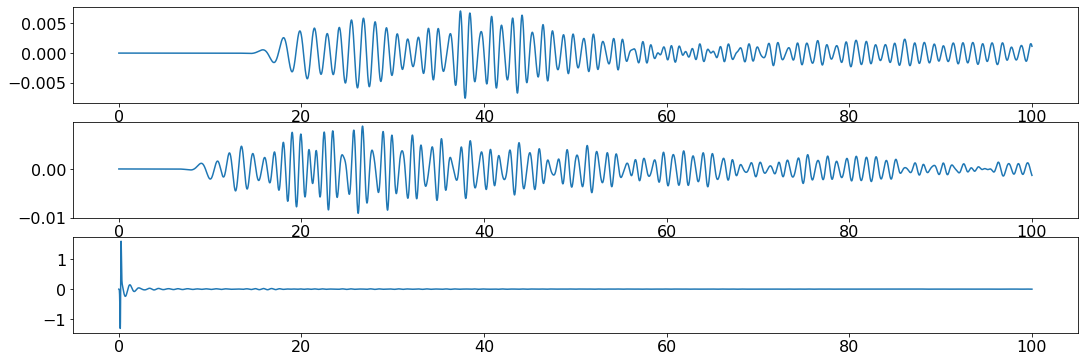

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6))

t=np.linspace(0,1000,50001)# the timerange couldn't be used so created this

plt.subplot(3,1,1)
plt.plot(t,rec.data[:,5])# avoiding boundaries, just left

plt.subplot(3,1,2)
plt.plot(t,rec.data[:,25])

plt.subplot(3,1,3)
plt.plot(t,rec.data[:,50])


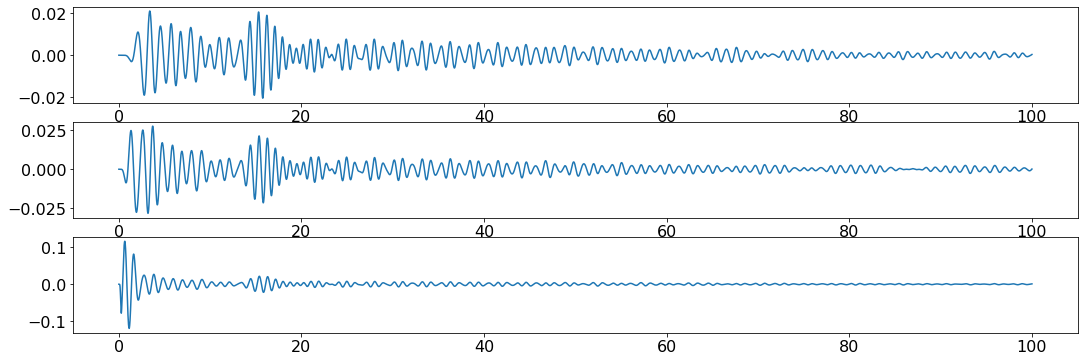

In [16]:
# checking the nearby receivers

plt.figure(figsize=(18,6))

t=np.linspace(0,1000,50001)# the timerange couldn't be used so created this

plt.subplot(3,1,1)
plt.plot(t,rec.data[:,45])# avoiding boundaries, just left

plt.subplot(3,1,2)
plt.plot(t,rec.data[:,47])

plt.subplot(3,1,3)
plt.plot(t,rec.data[:,49])

Checking for the possibility of detection we have that the least count of the accelerometer for +-2g mode is 0.061mg, so we can easily detect some change for these accelerometers.